# Exercises

In [23]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)


In [25]:
# download data for the lesson (this can take a few minutes)
#download_data('https://surfdrive.surf.nl/files/index.php/s/HeYXPdvMO87fbq7')

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. 

In [26]:
# set path to video of the full field of view
input_tif_file_path_FOV = 'data/calcium_video.tif'   
input_tif_file_path = 'data/caiman_video_trial_0.tif'  

In [27]:
# load movie and compute mean imges with caiman functions
original_movie = cm.load(input_tif_file_path)
mean_image = cm.summary_images.mean_image(input_tif_file_path)
correlation_image,pnr_image = cm.summary_images.correlation_pnr(original_movie,swap_dim=False)

In [29]:
# Define parameters for motion correction in a dictionary

parameters_motion_correction = { 'pw_rigid': True,       # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 
                                'use_cuda': False, 
                                'nonneg_movie': True,
                                'border_nan': 'copy'}




# We compute and store the minimum value of the movie, that the algorithm needs to make values all positive
original_movie = cm.load(input_tif_file_path)
parameters_motion_correction['min_mov'] = np.min(original_movie) 

# pass parameters to caiman object
opts = params.CNMFParams(params_dict = parameters_motion_correction)

In [30]:
n_processes = psutil.cpu_count() # counts local cpus
cm.cluster.stop_server() #stop any already running clusters
# Start a new cluster
c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                 n_processes=n_processes,
                                                 single_thread=False)

In [31]:
#make directory to save motion corrected videos
Path("data/motion_corrected").mkdir(parents=True, exist_ok=True)

#create an object for motion correction
mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))
# Perform rigid motion correction
mc.motion_correct_rigid(save_movie = True, template = None)

#perform non-rigid motion correction
total_template_rig = mc.total_template_rig
mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
fname_tot_els = mc.fname_tot_els[0]

#reshape memmap files for source extraction
m_els = cm.load(fname_tot_els)
fname_tot_els  = m_els.save('motion_corrected_video.mmap',  order='C')
Path(fname_tot_els).rename(f"data/motion_corrected/{fname_tot_els}")



Decode mmap filename data\caiman_video_trial_0_els__d1_300_d2_400_d3_1_order_F_frames_500.mmap


WindowsPath('data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap')

In [33]:
# load motion corrected video
input_mmap_file_path = 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

Decode mmap filename data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap


In [34]:
# compute correlation and pnr images 
gSig = 9
corr_image, pnr_image = cm.summary_images.correlation_pnr(images[::1], gSig=gSig,swap_dim=False)

figure, axes = plt.subplots(1, 2,figsize=(10,5))
axes[0].imshow(corr_image)
axes[0].set_title('Correlation image')
axes[1].imshow(pnr_image)
axes[1].set_title('PNR image')
    

In [36]:
# create dictionary with source extraction parameters

parameters_source_extraction ={ 'fr': 10,               # movie frame rate
                               'decay_time': 0.1,       # length of a typical transient in seconds
                               'min_corr': 0.7,   # min peak value from correlation image
                               'min_pnr': 7,     # min peak to noise ration from PNR image
                                'p': 1,                # order of the autoregressive system 
                               'K': None,              # upper bound on number of components per patch, in general None
                               'gSig': (4, 4),         # gaussian width of a 2D gaussian kernel, which approximates a neuron
                               'gSiz': (17, 17),       # average diameter of a neuron, in general 4*gSig+1
                               'ring_size_factor': 1.4, # radius of ring is gSiz*ring_size_factor
                               'merge_thr': 0.7, 'rf': 60,
                               'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                               'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2,
                               'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                               'update_background_components': True,
                               'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                               'del_duplicates': True, 'only_init': True}
# create caiman parameters objects
opts = params.CNMFParams(params_dict=parameters_source_extraction)

In [38]:
cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
cnmf_object.fit(images)

In [81]:
# Save the cnmf object as a hdf5 file
Path("data/source_extracted").mkdir(parents=True, exist_ok=True)
output_cnmf_file_path = 'data/source_extracted/calcium_video_0_cnmf.hdf5'
cnmf_object.save(output_cnmf_file_path)


# plot temporal traces
#figure, axes = plt.subplots(1,figsize=(10,5))
#C_0 = cnmf_object.estimates.C.copy()
#C_0[1] += C_0[0].min()
#for i in range(1, len(C_0)):
#    C_0[i] += C_0[i].min() + C_0[:i].max()
#    axes.plot(C_0[i],c='k')
#axes.set_xlabel('time (frames)')
#axes.set_yticks([])
#sns.despine()
#axes.set_ylabel('activity')


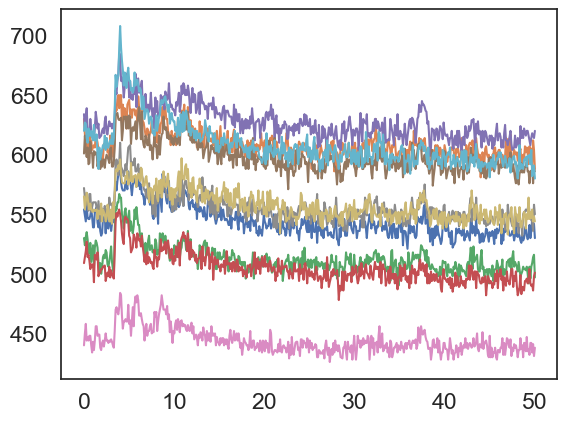

In [84]:
#temporal traces for randomly chosen pixels
random_pixels = np.empty([500,10]) #10 pixels

for i in range(10):
    random_pixels[:,i] = original_movie[:500,np.random.randint(0,300),np.random.randint(0,400)]


time_frames = np.linspace(1,500,1)
plt.figure()
for j in range(10):
    plt.plot(time,random_pixels[:,j])

**B.** Temporal statistics
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to differ a neuron from the background?

Text(0, 0.5, 'count')

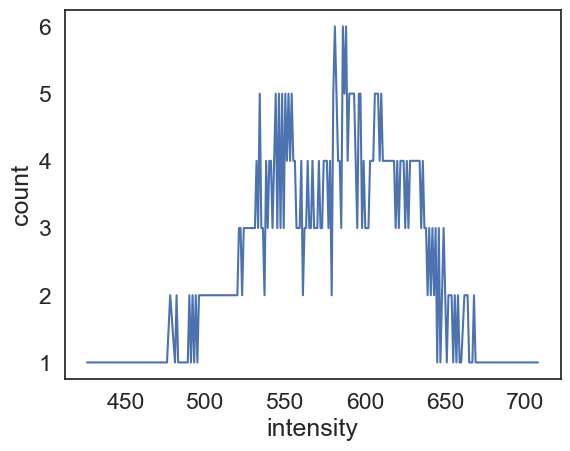

In [85]:
value_range = np.unique(random_pixels)

count = np.zeros([len(value_range)])
for i in range(len(value_range)):
    
    for j in range(10):
        if value_range[i] in random_pixels[:,j]:
            count[i] += 1

plt.figure()
plt.plot(value_range,count)
plt.xlabel('intensity')
plt.ylabel('count')


There are large variations in number of pixels that show certain intensities. From this the number of active pixels/neurons can be determined. Backgound should alays show the same intensity (with small variantions), while neurons have highly differing intensities throughout time.

* If we can already see the calcium traces from the row data, why do we need to do a segmentation of the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces? 